In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
import missingno as msno
import math

# Data Ingestion

In [2]:
#importando as bases que serão usadas e concatenadas

base_cinema = pd.read_json('BaseCinema_v3.json',lines=True)
#base_cinema.head()

base_detalhes = pd.read_json('BaseCinemaDetalhes_v3.json',lines=True)
#base_detalhes.head()

base_elenco1 = pd.read_json('BaseCinemaElenco.json',lines=True)
base_elenco3 = pd.read_json('BaseCinemaElenco_v3.json',lines=True)
base_elenco4 = pd.read_json('BaseCinemaElenco_v4.json',lines=True)
base_elenco5 = pd.read_json('BaseCinemaElenco_v5.json',lines=True)

out = base_elenco1
dfs_elenco = [base_elenco3, base_elenco4, base_elenco5]
for df in dfs_elenco:
    out = out.merge(df, how='outer')

base_elenco = out
base_elenco.drop_duplicates(keep='first', inplace=True)
#base_elenco.head()

base_imdb = pd.read_json('BaseCinemaIMDB_V1.json',lines=True)
#base_imdb.head()

In [3]:
#renomeando colunas para facilitar concat

base_cinema = base_cinema[['New_ID', 'genre_ids', 'id','original_language', 'popularity','release_date', 'title', 'vote_count', 'ano']]
base_detalhes = base_detalhes[['imdb_id', 'revenue', 'runtime','id']]

In [4]:
#início do merge nas bases

df_cinema = base_cinema.merge(base_detalhes, on='id', how='left')

df_elenco = base_elenco[['gender','id','known_for_department', 'name', 'ID_Filme']]

base_elenco['popularity'] = base_elenco['popularity'].astype('int')
base_acting = base_elenco.loc[base_elenco['known_for_department'] == 'Acting']
base_acting = base_acting.rename(columns={'popularity':'actors_popularity'})
base_acting_grouped = base_acting.groupby(['ID_Filme'])['actors_popularity'].sum()

base_directing = base_elenco.loc[base_elenco['known_for_department'] == 'Directing']
base_directing = base_directing.rename(columns={'popularity':'directors_popularity'})
base_directing_grouped = base_directing.groupby(['ID_Filme'])['directors_popularity'].sum()

df_elenco = df_elenco.join(base_acting_grouped, on='ID_Filme', how='left')
df_elenco = df_elenco.join(base_directing_grouped, on='ID_Filme', how='left')

df_cinema.rename(columns={'id':'ID_Filme'}, inplace= True)
df_elenco = df_elenco[['ID_Filme','actors_popularity', 'directors_popularity']]

df_cinema = df_cinema.merge(df_elenco, on='ID_Filme', how='left')

base_imdb.rename(columns={'id':'imdb_id'}, inplace=True)
base_imdb = base_imdb[['imdb_id', 'type','contentRating', 'imDbRating', 'metacriticRating','awards']]

df_cinema = df_cinema.merge(base_imdb, on='imdb_id', how='left')

df_cinema = df_cinema.drop_duplicates(subset='ID_Filme')

#export para csv caso desejável
#df_cinema.to_csv('base_projeto_integrador.csv', encoding='utf-8')

#importando a base (caso tenha sido gerada em outro local)
#df = pd.read_csv('base_projeto_integrador.csv', sep=',', low_memory=False, encoding='UTF-8')
#df = df.iloc[:,1:]

In [5]:
#export da base gerada para EDA
#df_cinema.to_excel('EDA.xlsx')

In [6]:
#ajuste de tipo para a coluna 'release+date'

df = df_cinema
df['release_date'] = pd.to_datetime(df['release_date'])

#filtro para considerar apenas filmes e ordenar pela data, popularidade e revenue (para posteriormente poder aplicar interpolarization)

df = df.loc[df['type'] == 'Movie']

<AxesSubplot:>

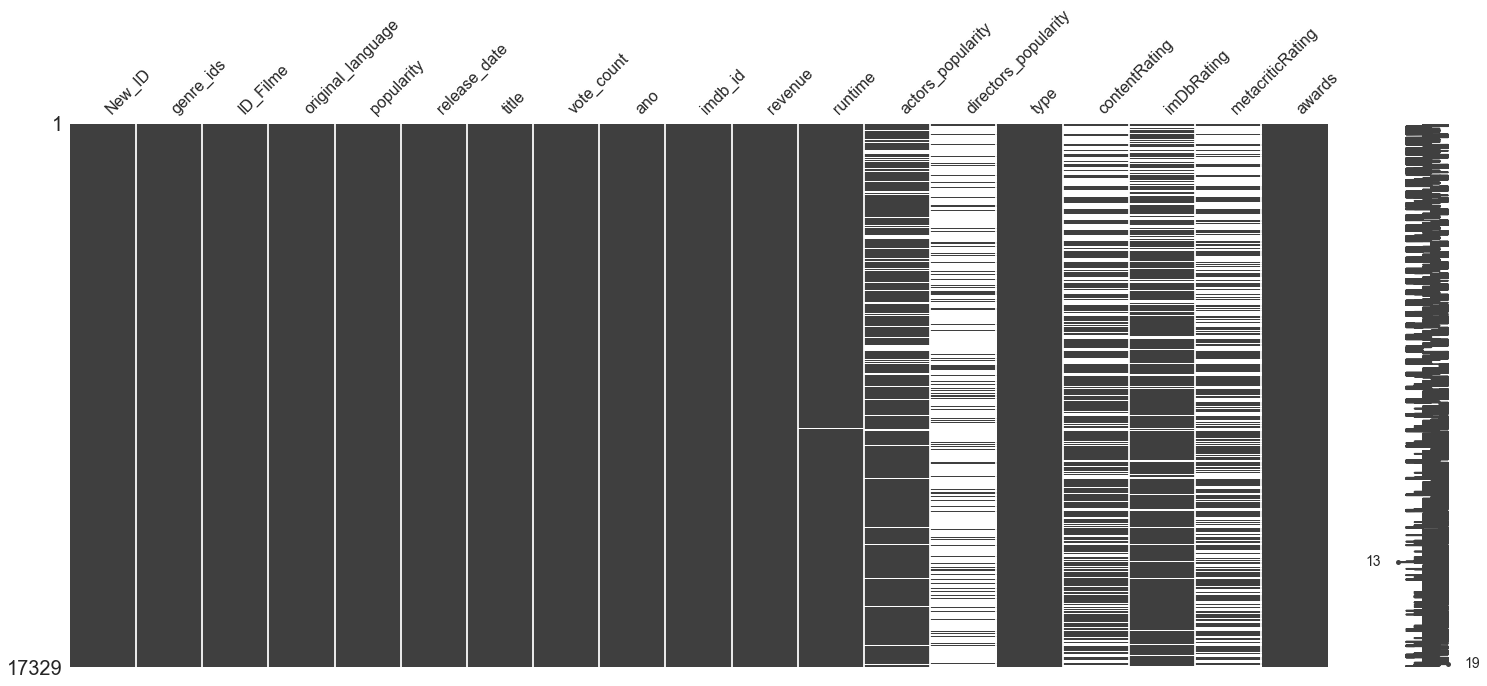

In [7]:
msno.matrix(df)

In [8]:
#filtro para puxar apenas linhas com informação na coluna 'actors_popularity' e 'revenue'

df = df.loc[(df['actors_popularity'].notnull()) & (df['revenue'].notnull())]

In [9]:
#transcrição da coluna 'contentRating'

df.loc[df['contentRating'].isin(['Tous publics','Approved','TV-MA']), ['contentRating']] = 'R'
df.loc[df['contentRating'].isin(['18A','18+','18','X','T']), ['contentRating']] = 'NC-17'
df.loc[df['contentRating'].isin(['12A','12','12+','13+','14A','TV-14','VM14','15','16','KT','TV-PG']), ['contentRating']] = 'PG-13'
df.loc[df['contentRating'].isin(['Tous publics avec avertissement','TV-G','TV-Y7','9','10','TV-Y7-FV']), ['contentRating']] = 'PG'
df.loc[df['contentRating'].isin(['Tous Public','Approved','6','6+','U','PA','TV-Y','K-11','K-12','AL','M', 'E10+']), ['contentRating']] = 'G'
df.loc[df['contentRating'].isin(['','Unrated']), ['contentRating']] = 'Not Rated'
df = df.replace(r'^\s*$', np.nan, regex=True)
df['contentRating'] = df['contentRating'].fillna('Not Rated')
df['contentRating'].value_counts()

Not Rated    7078
R            4217
PG-13        2539
PG           1369
G             236
NC-17          38
MA-17           1
Name: contentRating, dtype: int64

In [10]:
#labelEncoder para 'contentRating'

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['contentRating_encoded'] = le.fit_transform(df['contentRating'])
df['contentRating_encoded'].value_counts()

3    7078
6    4217
5    2539
4    1369
0     236
2      38
1       1
Name: contentRating_encoded, dtype: int64

In [11]:
#como as colunas "directors_popularity" / 'contentRating' / 'metacriticRating' possuirem poucas entradas (~550 linhas), iremos desconsiderar do modelo para evitar perder uma grande massa de dados

cols = ['directors_popularity', 'metacriticRating']
df.drop(columns=cols, axis=1, inplace=True)

In [12]:
#feature enginnering com Regex para criação de colunas com as premiações
import re

#cria variáveis numéricas com base no campo "awards"
df['Oscar_win'] = df['awards'].str.extract(r"Won (\d+) Oscar")
df['Oscar_win'] = df['Oscar_win'].fillna(0)
df['Oscar_win'] = df['Oscar_win'].astype(int)

df['Oscar_nomination'] = df['awards'].str.extract(r"Nominated for (\d+) Oscar")
df['Oscar_nomination'] = df['Oscar_nomination'].fillna(0)
df['Oscar_nomination'] = df['Oscar_nomination'].astype(int)

df['Other_awards_win'] = df['awards'].str.extract(r"(\d+) win")
df['Other_awards_win'] = df['Other_awards_win'].fillna(0)
df['Other_awards_win'] = df['Other_awards_win'].astype(int)

df['Other_awards_nominations'] = df['awards'].str.extract(r"(\d+) nomination")
df['Other_awards_nominations'] = df['Other_awards_nominations'].fillna(0)
df['Other_awards_nominations'] = df['Other_awards_nominations'].astype(int)

#ajusta casos onde Win > Nomination
df['Oscar_nomination'] = df.apply(lambda x: x['Oscar_win'] if x['Oscar_win'] > x['Oscar_nomination'] else x['Oscar_nomination'], axis=1)
df['Other_awards_win'] = df.apply(lambda x: x['Other_awards_nominations'] if x['Other_awards_win'] > x['Other_awards_nominations'] else x['Other_awards_win'], axis=1)

df = df.drop('awards', axis=1)

In [13]:
df['revenue'].value_counts()

0.0            3065
10000.0          43
500000.0         40
100000.0         40
2000000.0        35
               ... 
123021750.0       1
4280982.0         1
447784.0          1
10921200.0        1
26.0              1
Name: revenue, Length: 10984, dtype: int64

In [14]:
#Como 'revenue' é nossa variável target e existem muitos registros nulos, iremos simular através da interpolação, para os data points com popularity / actors_popularity.

df = df.sort_values(['release_date', 'popularity', 'actors_popularity'], ascending=[True, True, True])

df['interpolation'] = 'Not used'
df.loc[df['revenue'] == 0, 'interpolation'] = 'Interpolated'
df.loc[df['revenue'] == 0, 'revenue'] = np.nan
df['revenue'] = df['revenue'].interpolate(method ='linear', limit_direction ='forward')

In [15]:
#ajusta 'imDbRating' para float
df['imDbRating'] = df['imDbRating'].astype(float)

#mesmo tratamento para imDbrating
df['imDbRating'].fillna(value=np.nan, inplace=True)
df.loc[df['imDbRating'].isna(), 'interpolation'] = 'Interpolated'
df['imDbRating'] = df['imDbRating'].interpolate(method ='linear', limit_direction ='forward')

<AxesSubplot:>

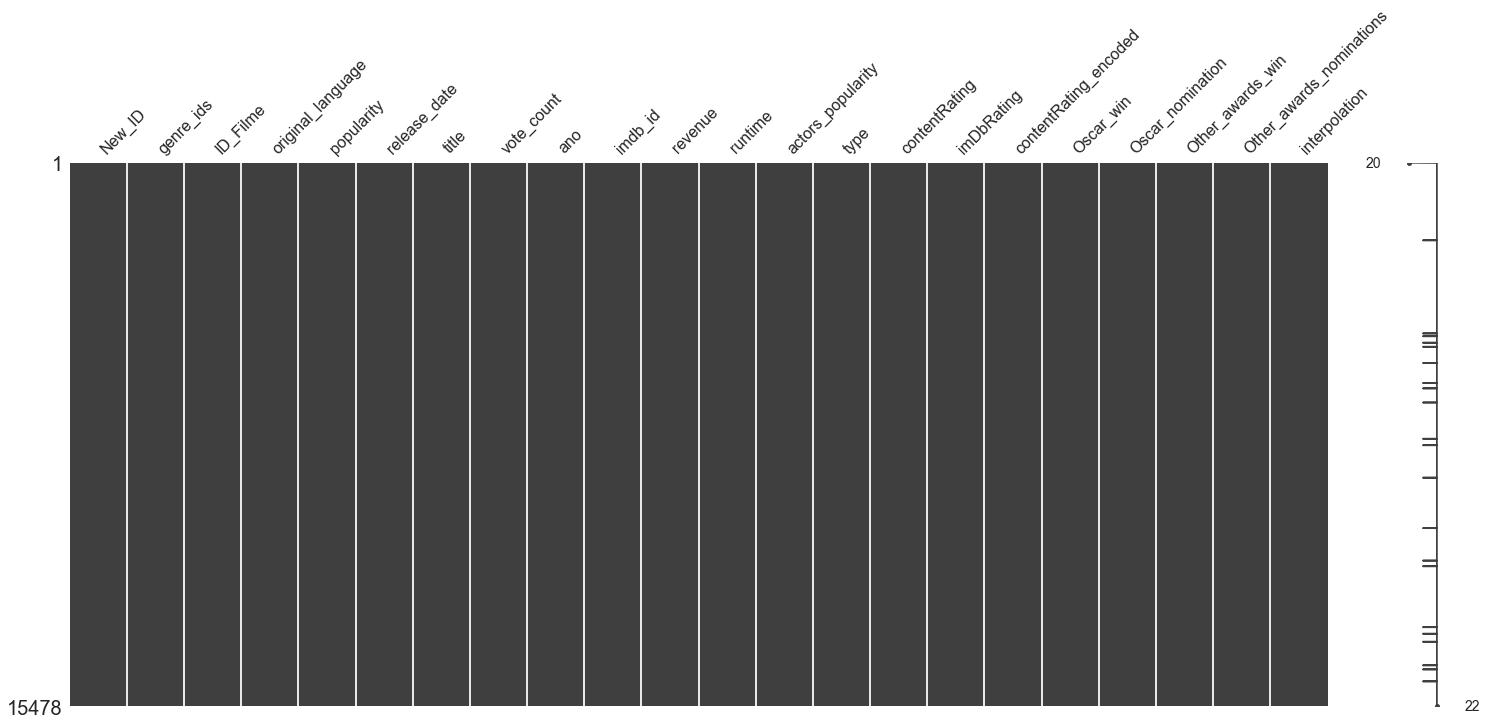

In [16]:
msno.matrix(df)

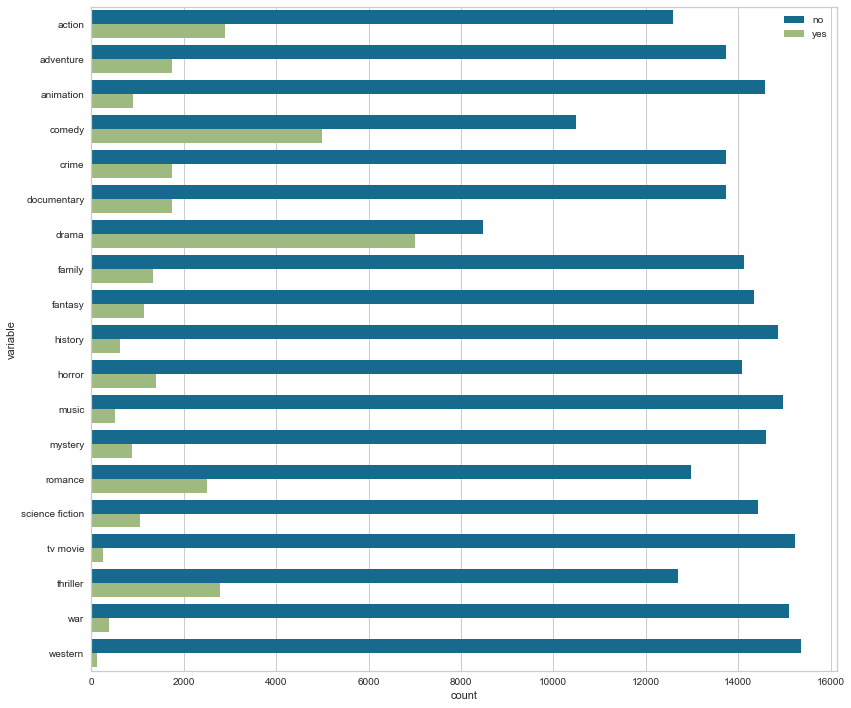

In [17]:
#criação de colunas com o gênero

#cria as dummies usando ',' como separador e da merge com o df principal
df = pd.concat([df, df['genre_ids'].str.get_dummies(sep=',')], axis = 1).drop('genre_ids', 1)

#cornojob de renomear colunas (nao encontrei outro jeito) para concatenar colunas iguais > https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee?language=pt-BR
df.columns = ['New_ID', 'ID_Filme', 'original_language', 'popularity',
       'release_date', 'title', 'vote_count', 'ano', 'imdb_id', 'revenue',
       'runtime', 'actors_popularity', 'type', 'contentRating', 'imDbRating','contentRating_encoded', 'Oscar_win',
       'Oscar_nomination', 'Other_awards_win', 'Other_awards_nominations', 'interpolation',
       'Music_a', 'Music_b', 'Romance_a', 'Romance_b', 'Family_a', 'Family_b',
       'War_a', 'War_b', 'TV Movie_a', 'TV Movie_b', 'Adventure_a', 'Adventure_b', 'Fantasy_a',
       'Fantasy_b', 'Animation_a', 'Animation_b', 'Drama_a', 'Drama_b', 'Horror_a', 'Horror_b', 'Action_a', 'Action_b',
       'Comedy_a', 'Comedy_b', 'History_a', 'History_b', 'Western_a', 'Western_b', 'Thriller_a', 'Thriller_b', 'Crime_a',
       'Crime_b', 'Science Fiction_a', 'Science Fiction_b', 'Mystery_a', 'Mystery_b', 'Documentary_a', 'Documentary_b',
       'Music_c', 'Music_d', 'Romance_c', 'Romance_d', 'Family_c', 'Family_d',
       'War_c', 'War_d', 'TV Movie_c', 'TV Movie_d', 'Adventure_c', 'Adventure_d', 'Fantasy_c',
       'Fantasy_d', 'Animation_c', 'Animation_d', 'Drama_c', 'Drama_d', 'Horror_c', 'Horror_d', 'Action_c', 'Action_d',
       'Comedy_c', 'Comedy_d', 'History_c', 'History_d', 'Western_c', 'Western_d', 'Thriller_c', 'Thriller_d', 'Crime_c',
       'Crime_d', 'Science Fiction_c', 'Science Fiction_d', 'Mystery_c', 'Mystery_d', 'Documentary_c', 'Documentary_d', 'dropme']

df['action'] = df['Action_a'] + df['Action_b'] + df['Action_c'] + df['Action_d']
df.loc[df['action'] > 0, 'action'] = 1

df['adventure'] = df['Adventure_a'] + df['Adventure_b'] + df['Adventure_c'] + df['Adventure_d']
df.loc[df['adventure'] > 0, 'adventure'] = 1

df['animation'] = df['Animation_a'] + df['Animation_b'] + df['Animation_c'] + df['Animation_d']
df.loc[df['animation'] > 0, 'animation'] = 1

df['comedy'] = df['Comedy_a'] + df['Comedy_b'] + df['Comedy_c'] + df['Comedy_d']
df.loc[df['comedy'] > 0, 'comedy'] = 1

df['crime'] = df['Crime_a'] + df['Crime_b'] + df['Crime_c'] + df['Crime_d']
df.loc[df['crime'] > 0, 'crime'] = 1

df['documentary'] = df['Crime_a'] + df['Crime_b'] + df['Crime_c'] + df['Crime_d']
df.loc[df['documentary'] > 0, 'documentary'] = 1

df['drama'] = df['Drama_a'] + df['Drama_b'] + df['Drama_c'] + df['Drama_d']
df.loc[df['drama'] > 0, 'drama'] = 1

df['family'] = df['Family_a'] + df['Family_b'] + df['Family_c'] + df['Family_d']
df.loc[df['family'] > 0, 'family'] = 1

df['fantasy'] = df['Fantasy_a'] + df['Fantasy_b'] + df['Fantasy_c'] + df['Fantasy_d']
df.loc[df['fantasy'] > 0, 'fantasy'] = 1

df['history'] = df['History_a'] + df['History_b'] + df['History_c'] + df['History_d']
df.loc[df['history'] > 0, 'history'] = 1

df['horror'] = df['Horror_a'] + df['Horror_b'] + df['Horror_c'] + df['Horror_d']
df.loc[df['horror'] > 0, 'horror'] = 1

df['music'] = df['Music_a'] + df['Music_b'] + df['Music_c'] + df['Music_d']
df.loc[df['music'] > 0, 'music'] = 1

df['mystery'] = df['Mystery_a'] + df['Mystery_b'] + df['Mystery_c'] + df['Mystery_d']
df.loc[df['mystery'] > 0, 'mystery'] = 1

df['romance'] = df['Romance_a'] + df['Romance_b'] + df['Romance_c'] + df['Romance_d']
df.loc[df['romance'] > 0, 'romance'] = 1

df['science fiction'] = df['Science Fiction_a'] + df['Science Fiction_b'] + df['Science Fiction_c'] + df['Science Fiction_d']
df.loc[df['science fiction'] > 0, 'science fiction'] = 1

df['tv movie'] = df['TV Movie_a'] + df['TV Movie_b'] + df['TV Movie_c'] + df['TV Movie_d']
df.loc[df['tv movie'] > 0, 'tv movie'] = 1

df['thriller'] = df['Thriller_a'] + df['Thriller_b'] + df['Thriller_c'] + df['Thriller_d']
df.loc[df['thriller'] > 0, 'thriller'] = 1

df['war'] = df['War_a'] + df['War_b'] + df['War_c'] + df['War_d']
df.loc[df['war'] > 0, 'war'] = 1

df['western'] = df['Western_a'] + df['Western_b'] + df['Western_c'] + df['Western_d']
df.loc[df['western'] > 0, 'western'] = 1

cols = ['Music_a', 'Music_b', 'Romance_a', 'Romance_b', 'Family_a', 'Family_b',
       'War_a', 'War_b', 'TV Movie_a', 'TV Movie_b', 'Adventure_a', 'Adventure_b', 'Fantasy_a',
       'Fantasy_b', 'Animation_a', 'Animation_b', 'Drama_a', 'Drama_b', 'Horror_a', 'Horror_b', 'Action_a', 'Action_b',
       'Comedy_a', 'Comedy_b', 'History_a', 'History_b', 'Western_a', 'Western_b', 'Thriller_a', 'Thriller_b', 'Crime_a',
       'Crime_b', 'Science Fiction_a', 'Science Fiction_b', 'Mystery_a', 'Mystery_b', 'Documentary_a', 'Documentary_b',
       'Music_c', 'Music_d', 'Romance_c', 'Romance_d', 'Family_c', 'Family_d',
       'War_c', 'War_d', 'TV Movie_c', 'TV Movie_d', 'Adventure_c', 'Adventure_d', 'Fantasy_c',
       'Fantasy_d', 'Animation_c', 'Animation_d', 'Drama_c', 'Drama_d', 'Horror_c', 'Horror_d', 'Action_c', 'Action_d',
       'Comedy_c', 'Comedy_d', 'History_c', 'History_d', 'Western_c', 'Western_d', 'Thriller_c', 'Thriller_d', 'Crime_c',
       'Crime_d', 'Science Fiction_c', 'Science Fiction_d', 'Mystery_c', 'Mystery_d', 'Documentary_c', 'Documentary_d', 'dropme']

df.drop(columns=cols, axis=1, inplace=True)

#check das dummies criadas
plt.figure(figsize=(12,10))
df_dummies = df.iloc[0:,21:].melt()
ax = sns.countplot(data=df_dummies, y='variable', hue='value')
ax.legend(labels=['no', 'yes'])
plt.tight_layout()
plt.show()


In [18]:
#labelEncoder para 'original_language'

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['original_language_encoded'] = le.fit_transform(df['original_language'])
df['original_language_encoded'].value_counts()

17    9311
23     650
60     647
18     595
35     543
      ... 
51       1
3        1
73       1
42       1
79       1
Name: original_language_encoded, Length: 83, dtype: int64

<AxesSubplot:>

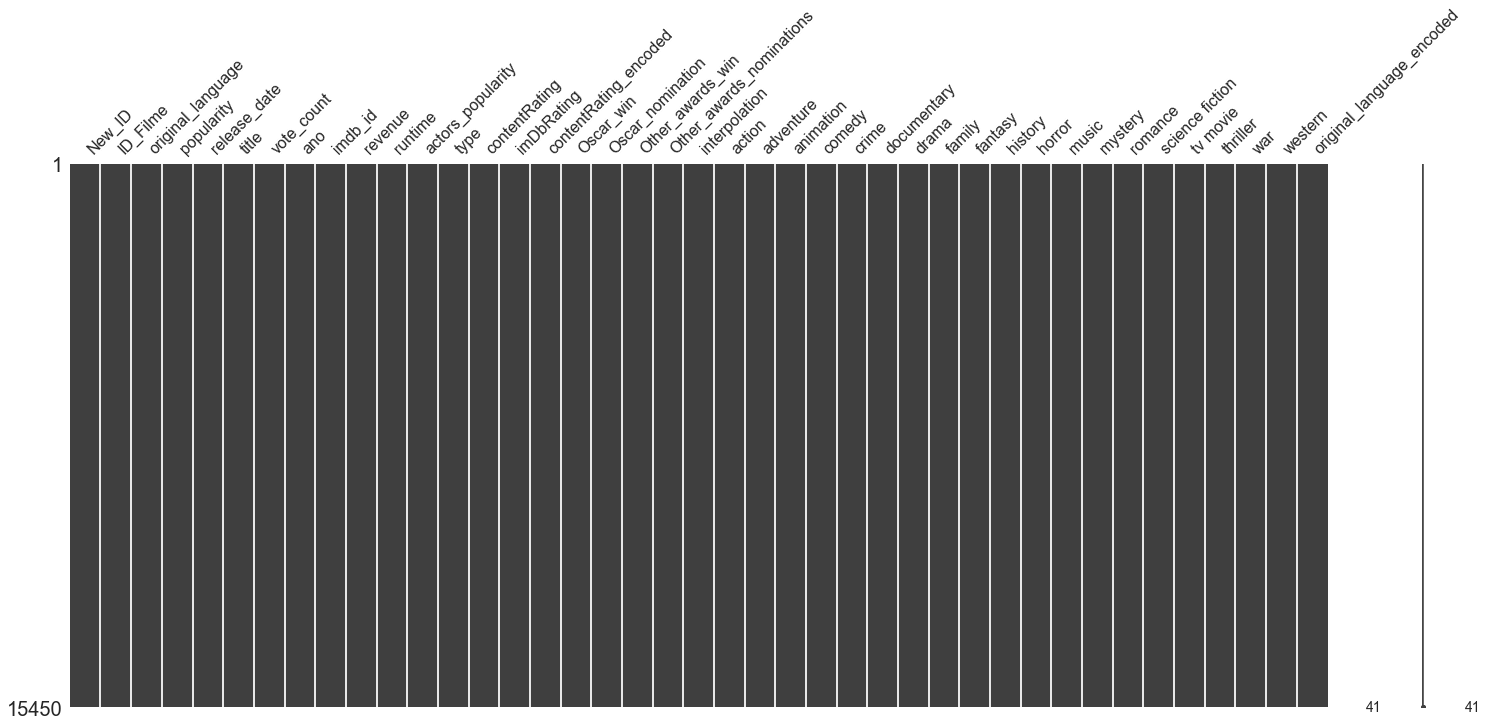

In [19]:
df = df.dropna()
msno.matrix(df)

# Clusterização

**Kmeans** 


In [20]:
#segregação das varíaveis categóricas e numéricas

df_num = df.select_dtypes(exclude='object')
df_num = pd.concat([df_num, df['imdb_id']], axis=1)


df_cat = df.select_dtypes('object')
df_cat = pd.concat([df_cat, df['imdb_id']], axis=1)

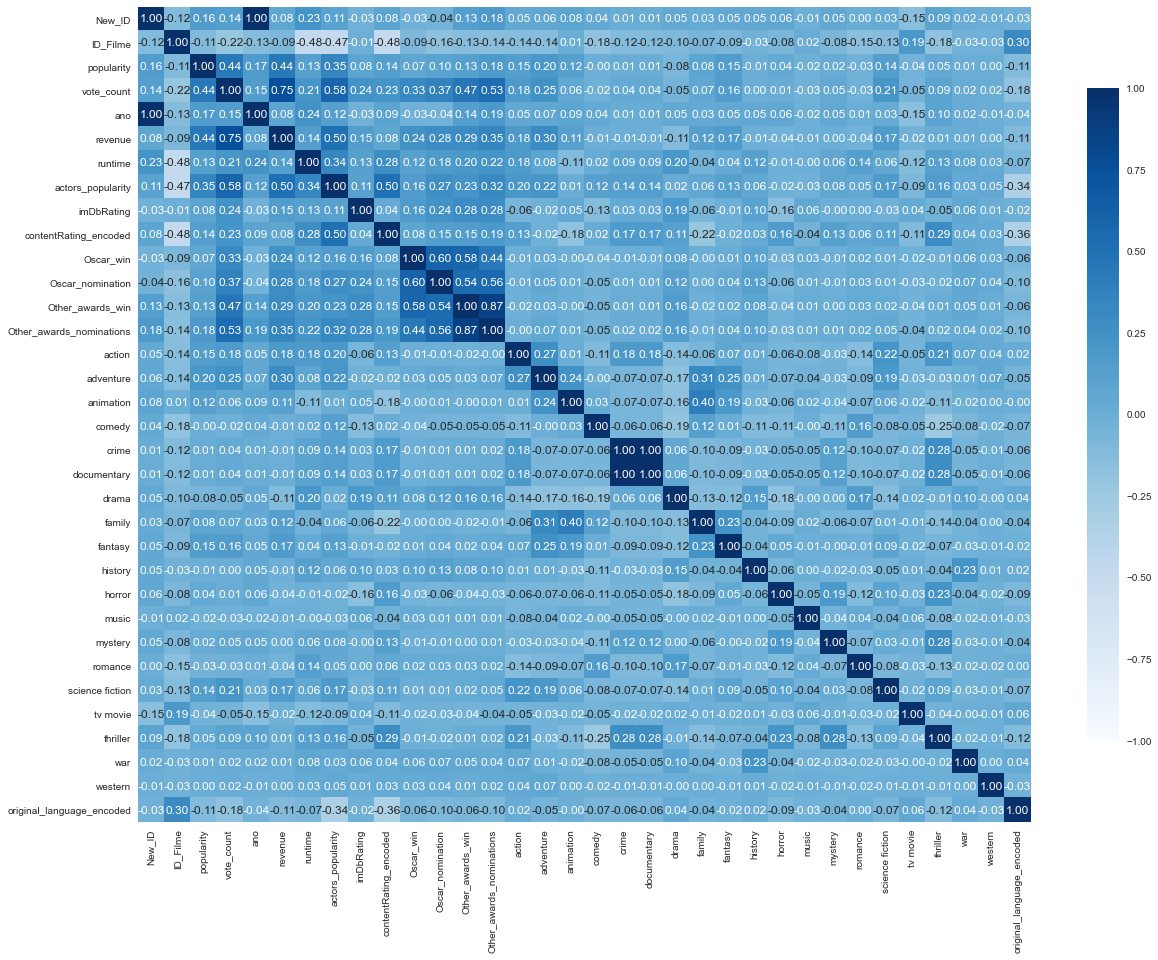

In [21]:
# get correlations
df_corr = df_num.corr()

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.show()

In [22]:
#reordena as colunas da base numérica para filtrar algumas variáveis que não serão usadas no modelo

df_num = df_num[['popularity', 'vote_count',
       'runtime', 'actors_popularity', 'imDbRating',
       'contentRating_encoded', 'Oscar_win', 'Oscar_nomination',
       'Other_awards_win', 'Other_awards_nominations', 'original_language_encoded', 'action',
       'adventure', 'animation', 'comedy', 'crime', 'documentary',
       'drama', 'family', 'fantasy', 'history', 'horror', 'music',
       'mystery', 'romance', 'science fiction', 'tv movie', 'thriller',
       'war', 'western', 'imdb_id', 'New_ID', 'ID_Filme', 'release_date', 'ano' , 'revenue']]
df_num.drop(['imdb_id', 'New_ID', 'ID_Filme', 'release_date', 'ano' , 'revenue'], axis=1, inplace=True)
df_num

,popularity,vote_count,runtime,actors_popularity,imDbRating,contentRating_encoded,Oscar_win,Oscar_nomination,Other_awards_win,Other_awards_nominations,...,history,horror,music,mystery,romance,science fiction,tv movie,thriller,war,western
5217,0.600,0,0.0,1.0,4.5,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85469,0.600,0,10.0,1.0,6.8,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94077,0.600,0,0.0,1.0,6.7,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197350,0.600,0,0.0,1.0,6.6,3,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
197991,0.600,0,0.0,1.0,6.0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11549616,9.539,29,0.0,64.0,5.6,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11547224,258.848,133,105.0,154.0,7.9,5,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
11549454,49.758,81,112.0,66.0,7.5,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11563857,2.439,4,74.0,19.0,4.2,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


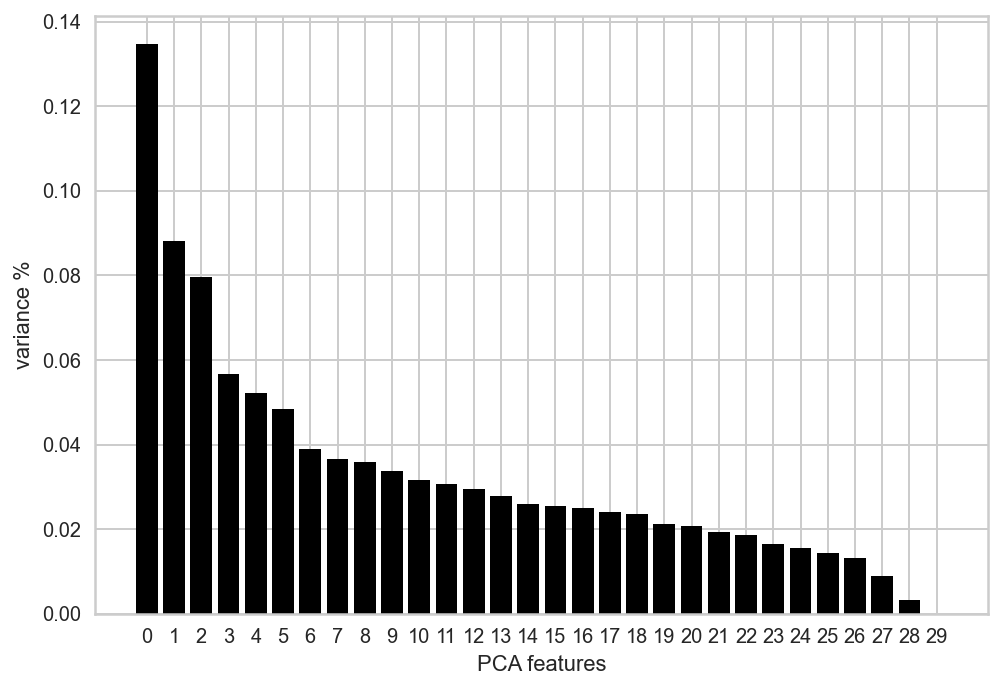

In [23]:
#PCA

# Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df_num)

# Create a PCA instance: pca
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

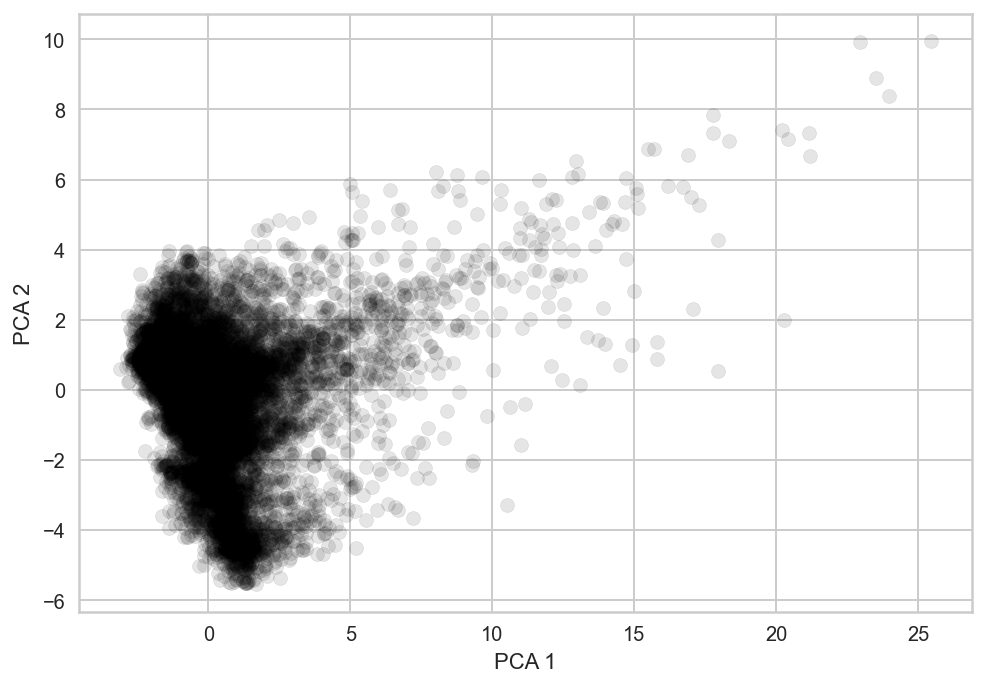

In [24]:
#plot com os dois principais componentes

plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

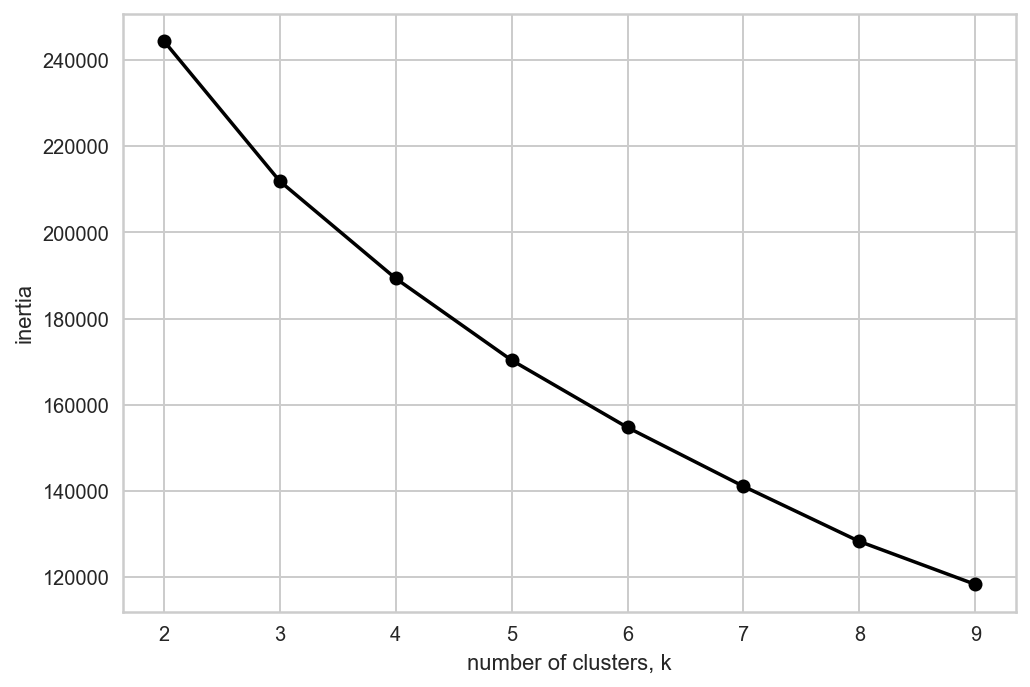

In [25]:
# plotando o gráfico do método elbow
ks = range(2, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:10])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [26]:
# filtra as colunas que serão usadas no K-Means
X = PCA_components.iloc[:,:10][PCA_components.iloc[:,:10].columns.to_list()]

# instancia a função para padronizar os dados
#scaler = StandardScaler()

# padroniza a matriz X
#X_scaled = scaler.fit_transform(X)

# instancia o algoritmo KMeans
kmeans = KMeans(n_clusters = 5, random_state = 42)

# fita com a matriz X padronizada
kmeans.fit(X)

# rótulos obtidos pelo K-means
labels = kmeans.labels_

# centróides
centroids = kmeans.cluster_centers_

# adiciona a coluna labels do rótulos obtidos pelo K-Means
X['labels'] = labels

In [27]:
X['labels'].value_counts()

4    6398
1    5645
2    1702
0    1337
3     368
Name: labels, dtype: int64

In [28]:
#testando kmeans com variável revenue(target)

df_num2 = df.select_dtypes(exclude='object')
df_num2 = pd.concat([df_num2, df['imdb_id']], axis=1)

df_num2.drop(['imdb_id', 'New_ID', 'ID_Filme', 'release_date', 'ano'], axis=1, inplace=True)

#PCA
# Standardize the data to have a mean of ~0 and a variance of 1
X_std2 = StandardScaler().fit_transform(df_num2)

# Create a PCA instance: pca
pca = PCA(n_components=31)
principalComponents = pca.fit_transform(X_std2)

# Save components to a DataFrame
PCA_components2 = pd.DataFrame(principalComponents)

# filtra as colunas que serão usadas no K-Means
X2 = PCA_components2.iloc[:,:10][PCA_components2.iloc[:,:10].columns.to_list()]

# instancia o algoritmo KMeans
kmeans = KMeans(n_clusters = 5, random_state = 42)

# fita com a matriz X padronizada
kmeans.fit(X2)

# rótulos obtidos pelo K-means
labels = kmeans.labels_

# centróides
centroids = kmeans.cluster_centers_

# adiciona a coluna labels do rótulos obtidos pelo K-Means
X2['labels'] = labels


**DBScan**

In [29]:
from sklearn.cluster import DBSCAN

# filtra as colunas que serão usadas no K-Means
#X2 = df_num.drop(['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance', 'science fiction', 'tv movie', 'thriller', 'war', 'western'], axis=1)
X3 = df_num
X3 = X3[X3.columns.to_list()]

clustering = DBSCAN(eps=110, min_samples=10).fit(X3)
cluster = clustering.labels_

# adiciona a coluna labels do rótulos obtidos pelo DBScan
X3['labels'] = cluster

len(set(cluster))

8

In [30]:
X3['labels'].value_counts()

 0    14865
-1      470
 4       48
 2       21
 3       16
 6       10
 5       10
 1       10
Name: labels, dtype: int64

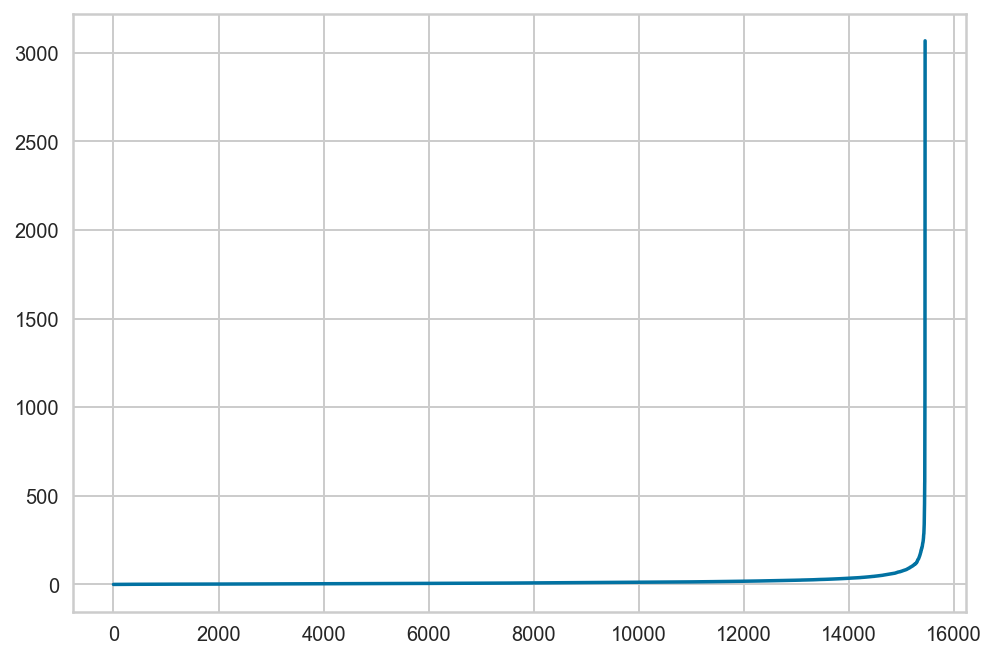

In [31]:
#Optimal eps value

from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X3)
distances, indices = nbrs.kneighbors(X3)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

**HCA**

In [32]:
from sklearn.cluster import AgglomerativeClustering

# filtra as colunas que serão usadas no K-Means
X4 = PCA_components.iloc[:,:10][PCA_components.iloc[:,:10].columns.to_list()]

cluster = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='ward')
cluster.fit_predict(X4)

# adiciona a coluna labels do rótulos obtidos pelo DBScan
X4['labels'] = cluster.labels_

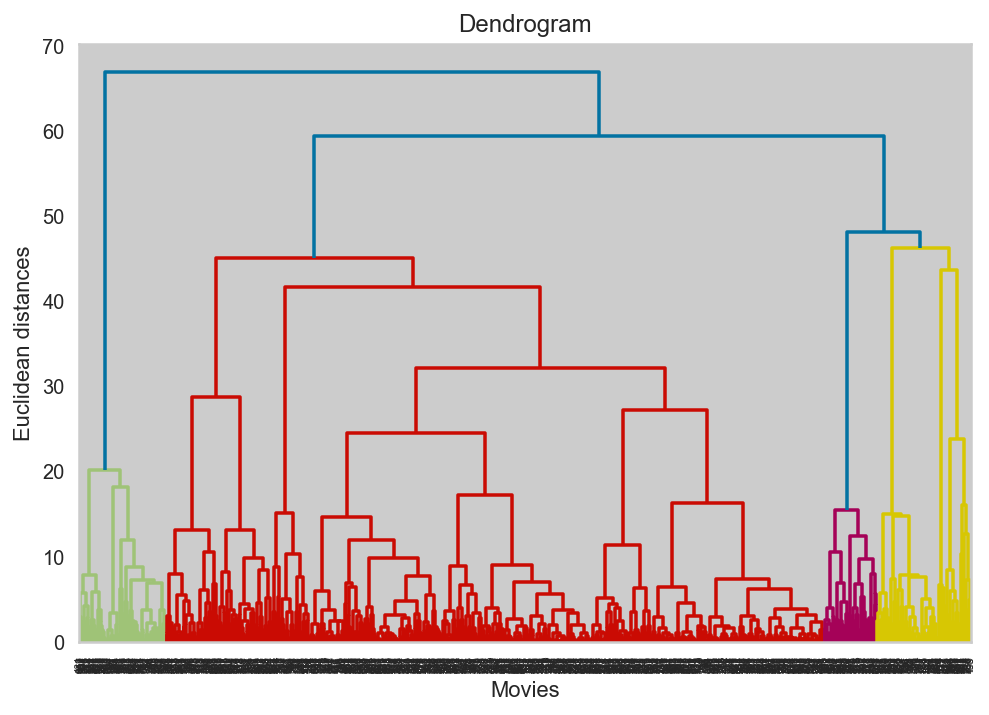

In [33]:
import scipy.cluster.hierarchy as sch

#Lets create a dendrogram variable linkage is actually the algorithm itself of hierarchical clustering and then in linkage we have to specify on which data we apply and engage
dendrogram = sch.dendrogram(sch.linkage(X4.values[:1000], method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Movies')
plt.ylabel('Euclidean distances')
plt.show()

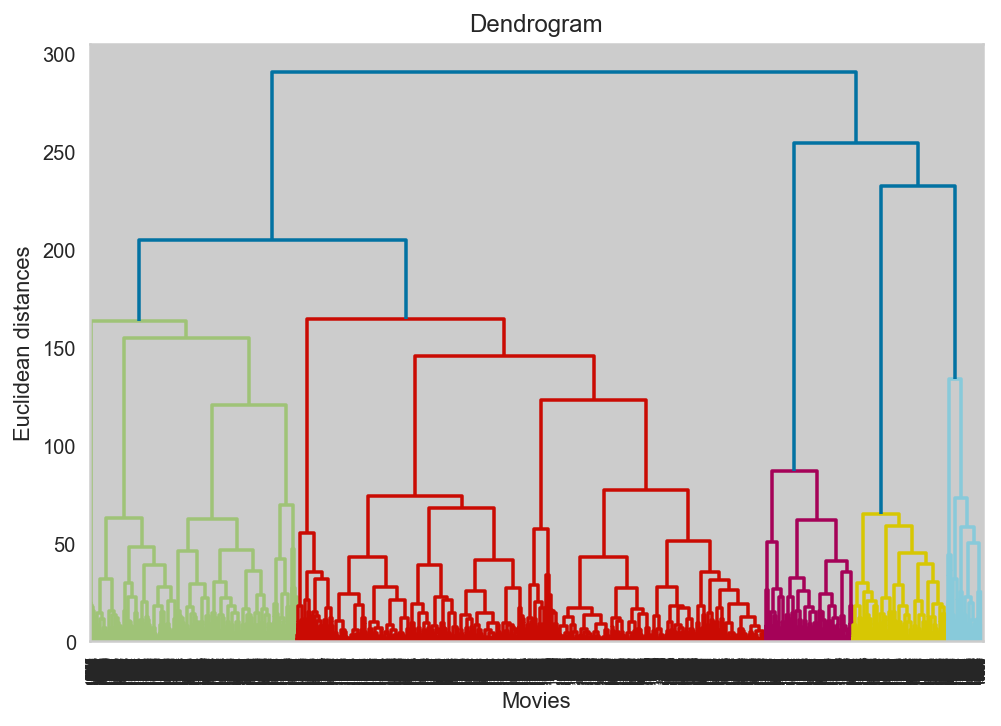

Wall time: 13min 44s


In [34]:
#%%time

#import scipy.cluster.hierarchy as sch

#Lets create a dendrogram variable linkage is actually the algorithm itself of hierarchical clustering and then in linkage we have to specify on which data we apply and engage

#dendrogram = sch.dendrogram(sch.linkage(X4.values, method  = "ward"))
#plt.title('Dendrogram')
#plt.xlabel('Movies')
#plt.ylabel('Euclidean distances')
#plt.show()

# Export

In [35]:
#ADICIONA OS LABELS DE CADA CLUSTERIZADOR

df_num = df_num.reset_index(drop=True)
df_num['labels_kmeans'] = X['labels']
df_num['labels_kmeans_revenue'] = X2['labels']
X3 = X3.reset_index(drop=True)
df_num['labels_DBScan'] = X3['labels']
df_num['labels_hca'] = X4['labels']

In [36]:
#merge nos Dfs para export e visualização no Pbi

PCA_components = PCA_components.reset_index(drop=True)
df_num = pd.concat([df_num, PCA_components], axis=1)

PCA_components2.columns = ['0_2', '1_2', '2_2', '3_2', '4_2', '5_2', '6_2', '7_2', '8_2', '9_2', '10_2', '11_2', '12_2', '13_2', '14_2', '15_2', '16_2',
       '17_2', '18_2', '19_2', '20_2', '21_2', '22_2', '23_2', '24_2', '25_2', '26_2', '27_2', '28_2', '29_2', '30_2']
PCA_components2 = PCA_components2.reset_index(drop=True)
df_num = pd.concat([df_num, PCA_components2], axis=1)

df = df.reset_index()
df_num = pd.concat([df_num, df[['imdb_id', 'revenue', 'title', 'ano', 'contentRating']]], axis=1)
#df_num = pd.concat([df_num, df['imdb_id']], axis=1)
#df_num = pd.concat([df_num, df['revenue']], axis=1)
#df_num = pd.concat([df_num, df['title']], axis=1)

In [37]:
#check para validar se labels foram devidamente atribuídas (podem ocorrer erros de index)

#pd.set_option('max_columns', None)
#df_num

In [38]:
#export

#df_num.to_csv('imDs_clusters.csv')
#df_num.to_excel('teste.xlsx')